# División de Ciencias e Ingenierías de la Universidad de Guanajuato
## Fundamentos de procesamiento digital de imágenes
## TAREA : Funciones de filtrado en frecuencia
### Profesor : Dr. Arturo González Vega
### Alumno : Gustavo Magaña López

In [1]:

import copy
import importlib
from typing import Tuple, List, NoReturn

import numpy as np
import scipy.fftpack as F
import scipy.io as io

import cv2
import matplotlib.image as img

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

import skimage
import skimage.morphology
import skimage.filters

from PIL import Image

import scipy.io as io

In [19]:
# Importamos todas nuestras funciones:
import mfilt_funcs as mine
importlib.reload(mine)
from mfilt_funcs import *

In [3]:
plt.rcParams['figure.figsize'] = (5, 5)

In [4]:
eps = np.finfo(float).eps
eps.setflags(write=False)

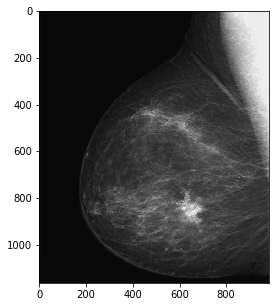

In [5]:
I = img.imread('imagenes/mama.tif')
plt.imshow(I, cmap='gray')

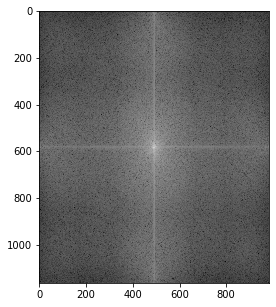

In [6]:
fft_viz(I)

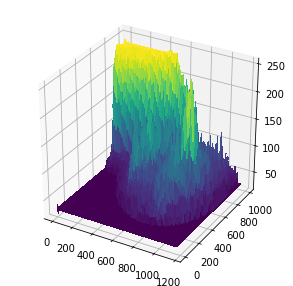

In [7]:
img_surf(I)

In [8]:
x = cv2.imread('imagenes/RadiografiaRuidoCoherente.jpg', 0)

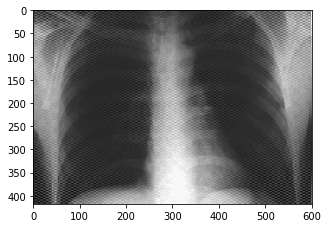

In [9]:
plt.imshow(x, cmap='gray')

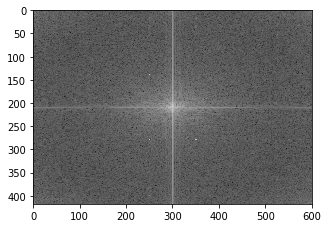

In [10]:
fft_viz(x)

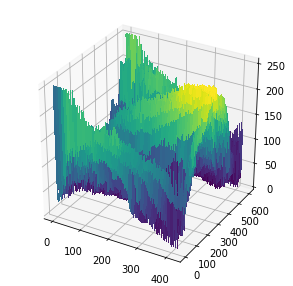

In [11]:
img_surf(x)

### 5.1 Filtro pasa bajos ideal con wc=64,

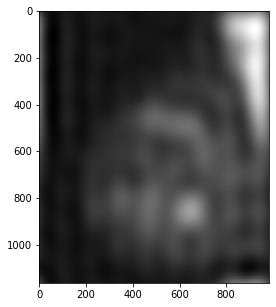

In [12]:
plt.imshow(
    filtra_maestra(I, Do=64, kind='lowpass', form='ideal'),
    cmap='gray'
)

### 5.2 Filtro pasa bajos butt con wc=64, orden=2

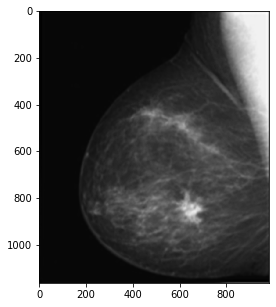

In [13]:
plt.imshow(
    filtra_maestra(I, Do=64, kind='lowpass', form='btw', n=2),
    cmap='gray'
)

### 5.3 Filtro pasa bajos gauss con wc=64

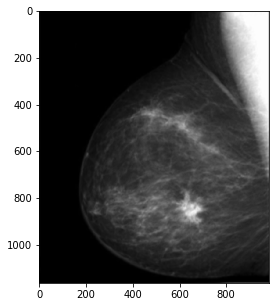

In [15]:
plt.imshow(
    filtra_maestra(I, Do=64, kind='lowpass', form='gauss'),
    cmap='gray'
)

### 5.4 Filtro pasa altos gauss con wc=64

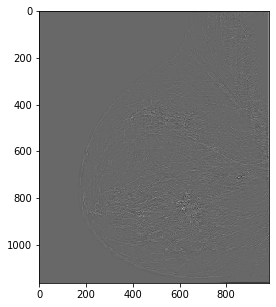

In [17]:
plt.imshow(
    filtra_maestra(I, Do=64, kind='highpass', form='gauss'),
    cmap='gray'
)

### 5.5 Filtro pasa bandas gauss con wc1=54, wc2=74

/Users/gml/Documents/IX/imagenes/MasterFilter/mfilt_funcs.py:389: RuntimeWarning: divide by zero encountered in true_divide
  H = 1.0 - np.exp(-1.0 * (D - Do**2)**2 / (w**2 * D) )


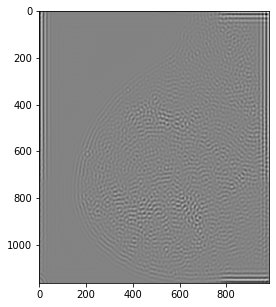

In [20]:
plt.imshow(
    filtra_maestra(I, wc1=54, wc2=74, kind='bandpass', form='gauss'),
    cmap='gray'
)

### 5.6 Filtro rechazo de bandas gauss con wc1=54, wc2=74

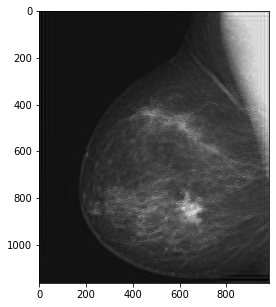

In [22]:
plt.imshow(
    filtra_maestra(I, wc1=54, wc2=74, kind='bandreject', form='gauss'),
    cmap='gray'
)